In [295]:
# using DBSCAN this time -- left turns
from pathlib import Path
from itertools import product

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler


In [296]:
here = Path.cwd()
root = next(p for p in [here, *here.parents] if (p / "data" / "processed").exists())

#creating 2 columns to identify source file and if ios or android
df = pd.read_csv(root / "data" / "processed" / "android" / "state1_clean.csv", header=0)
df.head() 

,is_ios,source_file,eventType,eventSampleSpeed,eventDurationSeconds,eventMilesDriven,eventSensorDetectionMthd,eventGPSSignalStrength,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius
0,0,android_turns.csv,4.0,10.394929,7.244125,0.016991,2.0,1.480796,17.323687,6.789408,1.046972,9.521707,69.319600,22.941639
1,0,android_turns.csv,4.0,9.401910,7.497719,0.016103,2.0,1.693853,6.197542,10.101060,1.153392,11.245602,84.723694,20.737572
2,0,android_turns.csv,5.0,11.290954,4.244563,0.008359,2.0,21.173470,11.229438,9.081976,5.708309,24.616348,105.462135,18.996666
3,0,android_turns.csv,5.0,12.743101,3.173500,0.007654,1.0,15.306123,10.714942,13.421639,3.099853,17.929585,57.610783,23.959110
4,0,android_turns.csv,5.0,8.986107,5.990321,0.013587,0.0,19.387754,2.729067,20.937756,1.197121,2.787075,16.806042,91.713660


In [297]:
df.drop(columns=['source_file'], inplace=True)

left_raw = df[df['eventType'] == 4].copy()

sub_df_left = left_raw.drop(columns=['is_ios', 'eventType', 'eventSampleSpeed', 'eventSensorDetectionMthd', 'eventGPSSignalStrength'])

eps = 1e-3
sub_df_left['speed_drop'] = sub_df_left['eventStartSpeed'] - sub_df_left['eventEndSpeed']
sub_df_left['speed_ratio'] = sub_df_left['eventEndSpeed'] / (sub_df_left['eventStartSpeed'].abs() + eps)
sub_df_left['avg_speed'] = 0.5 * (sub_df_left['eventStartSpeed'] + sub_df_left['eventEndSpeed'])
sub_df_left['turn_intensity'] = sub_df_left['gyroAngleChange'] / (sub_df_left['eventDurationSeconds'].abs() + eps)
sub_df_left['curvature_mi'] = sub_df_left['gyroAngleChange'] / (sub_df_left['eventMilesDriven'].abs() + eps)
sub_df_left['inverse_radius'] = 1.0 / (sub_df_left['mems_radius'].abs() + eps)
sub_df_left['abs_angle_change'] = sub_df_left['gyroAngleChange'].abs()

feature_cols = [
    'eventDurationSeconds',
    'eventMilesDriven',
    'eventStartSpeed',
    'eventEndSpeed',
    'memsMedianHorizontalNorm',
    'gyro_angular_change_per_second',
    'gyroAngleChange',
    'mems_radius',
    'speed_drop',
    'speed_ratio',
    'avg_speed',
    'turn_intensity',
    'curvature_mi',
    'inverse_radius',
    'abs_angle_change',
]

sub_df_left = sub_df_left[feature_cols]
sub_df_left.shape


(519, 15)

In [298]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sub_df_left)   # or your features df
df_scaled = pd.DataFrame(X_scaled, columns=sub_df_left.columns, index=sub_df_left.index)
df_scaled.head()

,eventDurationSeconds,eventMilesDriven,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius,speed_drop,speed_ratio,avg_speed,turn_intensity,curvature_mi,inverse_radius,abs_angle_change
0,0.767387,-0.207915,0.425411,-1.244836,-0.765402,-0.937468,-0.102154,0.052161,2.537685,-1.114773,-0.420264,-0.943224,-0.245076,-0.483587,-0.102154
1,0.872258,-0.241333,-0.856979,-0.851578,-0.644344,-0.578125,0.436955,-0.051357,-0.047272,0.081399,-0.903799,-0.587335,0.139658,-0.446723,0.436955
6,-0.595794,-0.345343,-0.160243,-0.385169,-0.079716,0.366729,-0.328203,-0.728113,0.331809,-0.386147,-0.286726,0.362852,-0.059666,0.426868,-0.328203
9,-0.013249,0.130658,0.968302,0.156358,0.913295,0.536492,0.605395,-0.430278,1.268393,-0.678203,0.601305,0.526021,-0.432065,-0.202391,0.605395
11,-0.161017,-0.024047,-0.483269,0.807166,0.511216,1.042071,0.825609,-0.511878,-1.967677,0.970444,0.161147,1.030398,-0.127549,-0.102587,0.825609


In [299]:
def compute_k_distance(X, min_samples):
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    distances, _ = neighbors.fit(X).kneighbors(X)
    return np.sort(distances[:, -1])


def propose_search_space(k_distances, base_min_samples, *, eps_quantiles=(0.85, 0.98), n_eps=15, min_samples_window=3):
    q_low, q_high = np.quantile(k_distances, eps_quantiles)
    if np.isclose(q_low, q_high):
        padding = max(q_high * 0.15, 0.05)
        q_low = max(q_low - padding, 1e-3)
        q_high = q_high + padding
    eps_values = np.round(np.linspace(q_low, q_high, n_eps), 3)
    eps_values = np.unique(eps_values)
    min_samples_values = list(range(max(2, base_min_samples - min_samples_window),
                                    base_min_samples + min_samples_window + 1))
    return eps_values, min_samples_values


def evaluate_dbscan_grid(X, eps_values, min_samples_values, *, metric='euclidean', min_clusters=2):
    records = []
    total_samples = len(X)
    for eps, min_samples in product(eps_values, min_samples_values):
        model = DBSCAN(eps=float(eps), min_samples=int(min_samples), metric=metric, n_jobs=-1)
        labels = model.fit_predict(X)
        noise_mask = labels == -1
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        sil = np.nan
        ch = np.nan
        if n_clusters >= min_clusters:
            core_mask = ~noise_mask
            core_labels = labels[core_mask]
            if core_mask.sum() >= n_clusters and len(np.unique(core_labels)) >= 2:
                sil = silhouette_score(X[core_mask], core_labels)
                ch = calinski_harabasz_score(X[core_mask], core_labels)

        non_noise_labels = labels[~noise_mask]
        if non_noise_labels.size:
            _, counts = np.unique(non_noise_labels, return_counts=True)
            min_cluster_frac = counts.min() / total_samples
            max_cluster_frac = counts.max() / total_samples
        else:
            min_cluster_frac = 0.0
            max_cluster_frac = 0.0

        records.append({
            "eps": float(eps),
            "min_samples": int(min_samples),
            "n_clusters": int(n_clusters),
            "noise_pct": float(noise_mask.mean()),
            "silhouette": float(sil) if not np.isnan(sil) else np.nan,
            "calinski": float(ch) if not np.isnan(ch) else np.nan,
            "min_cluster_frac": float(min_cluster_frac),
            "max_cluster_frac": float(max_cluster_frac),
        })
    df = pd.DataFrame(records)
    df["eps"] = df["eps"].round(3)
    return df


def rank_dbscan_results(results_df, *, min_clusters=3, max_noise=0.35, min_cluster_frac=0.05):
    scored = results_df.copy()
    scored['silhouette_filled'] = scored['silhouette'].fillna(-1.0)
    scored['score'] = scored['silhouette_filled'] - 0.5 * scored['noise_pct']
    scored.loc[scored['n_clusters'] < min_clusters, 'score'] -= 0.75
    scored.loc[scored['noise_pct'] > max_noise, 'score'] -= 0.5
    scored.loc[scored['min_cluster_frac'] < min_cluster_frac, 'score'] -= 0.25
    scored = scored.sort_values(
        ['score', 'silhouette_filled', 'noise_pct'],
        ascending=[False, False, True]
    )
    return scored.reset_index(drop=True)


def plot_heatmap(df, value_col, title, *, cmap="viridis", annot=False, fmt=".2f"):
    pivot = df.pivot_table(index="min_samples", columns="eps", values=value_col, aggfunc="mean")
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, cmap=cmap, annot=annot, fmt=fmt if annot else "", cbar_kws={"label": value_col})
    plt.title(title)
    plt.xlabel("eps")
    plt.ylabel("min_samples")
    plt.tight_layout()
    plt.show()


def summarize_clusters(labels):
    unique, counts = np.unique(labels, return_counts=True)
    summary = pd.DataFrame({"cluster": unique, "count": counts}).sort_values("cluster")
    summary["pct"] = summary["count"] / summary["count"].sum()
    return summary.reset_index(drop=True)


def silhouette_without_noise(X, labels):
    mask = labels != -1
    if mask.sum() < 2:
        return np.nan
    filtered_labels = labels[mask]
    if len(np.unique(filtered_labels)) < 2:
        return np.nan
    return silhouette_score(X[mask], filtered_labels)


def project_pca(X, n_components=3):
    pca = PCA(n_components=n_components)
    coords = pca.fit_transform(X)
    return coords, pca


def plot_3d_clusters(X, labels, *, figsize=(9, 6)):
    coords, pca = project_pca(X, 3)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    unique_labels = np.unique(labels)
    palette = sns.color_palette('viridis', n_colors=max(len(unique_labels), 1))
    color_iter = iter(palette)

    for lab in unique_labels:
        mask = labels == lab
        if lab == -1:
            color = 'gray'
            label = 'Noise'
        else:
            color = next(color_iter)
            label = f'Cluster {lab}'
        ax.scatter(
            coords[mask, 0],
            coords[mask, 1],
            coords[mask, 2],
            s=12,
            color=color,
            alpha=0.8,
            label=label,
        )

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.set_title('DBSCAN Clusters (3D PCA projection)')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    return coords, pca


def plot_feature_boxplots(feature_df, labels, *, max_cols=3, value_label='value', figsize_scale=3.5):
    plot_df = feature_df.copy()
    plot_df['cluster'] = labels
    features = [col for col in plot_df.columns if col != 'cluster']
    if not features:
        raise ValueError('feature_df must contain at least one feature column.')

    n_features = len(features)
    ncols = min(max_cols, n_features)
    nrows = int(np.ceil(n_features / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize_scale, nrows * figsize_scale), squeeze=False)

    for idx, feature in enumerate(features):
        r, c = divmod(idx, ncols)
        ax = axes[r][c]
        sns.boxplot(data=plot_df, x='cluster', y=feature, ax=ax)
        ax.set_title(feature)
        ax.set_xlabel('Cluster')
        ax.set_ylabel(value_label)

    for idx in range(n_features, nrows * ncols):
        axes.flat[idx].set_visible(False)

    plt.tight_layout()
    plt.show()


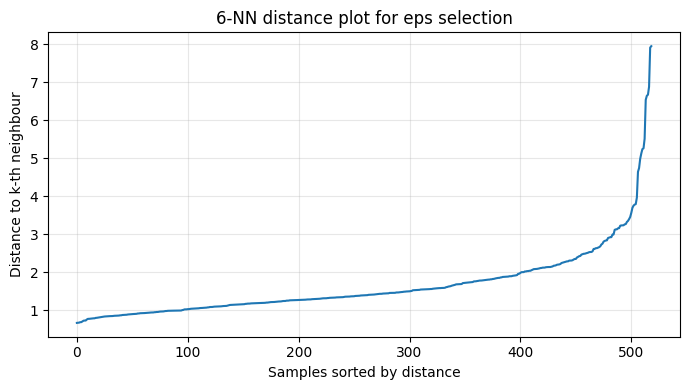

Evaluating eps in [0.100, 2.000] and min_samples in [3, 9]


,eps,min_samples,n_clusters,noise_pct,silhouette,calinski,min_cluster_frac,max_cluster_frac,silhouette_filled,score
0,1.762,6,3,0.181118,0.367697,83.470509,0.009634,0.784200,0.367697,0.027138
1,1.842,4,3,0.123314,0.337076,87.881641,0.007707,0.838150,0.337076,0.025419
2,1.762,4,3,0.142582,0.343783,90.608104,0.007707,0.818882,0.343783,0.022492
3,2.000,4,3,0.096339,0.320332,86.745404,0.007707,0.863198,0.320332,0.022162
4,1.921,4,3,0.111753,0.325815,84.068370,0.007707,0.849711,0.325815,0.019938
5,1.762,3,4,0.127168,0.293065,64.814694,0.005780,0.828516,0.293065,-0.020518
6,1.683,5,3,0.196532,0.299825,82.632618,0.015414,0.764933,0.299825,-0.048440
7,2.000,3,4,0.088632,0.213143,60.078526,0.005780,0.865125,0.213143,-0.081173
8,1.921,3,4,0.100193,0.216769,58.067313,0.005780,0.855491,0.216769,-0.083328
9,1.604,3,7,0.156069,0.225259,43.473916,0.005780,0.780347,0.225259,-0.102776


In [300]:
X_data = df_scaled.values
n_samples, n_features = X_data.shape
base_min_samples = max(3, int(np.ceil(np.log10(n_samples)) * 2))

k_distances = compute_k_distance(X_data, base_min_samples)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(k_distances)
ax.set_title(f"{base_min_samples}-NN distance plot for eps selection")
ax.set_xlabel("Samples sorted by distance")
ax.set_ylabel("Distance to k-th neighbour")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

_, min_samples_values = propose_search_space(
    k_distances,
    base_min_samples,
    eps_quantiles=(0.85, 0.98),
    n_eps=15,
    min_samples_window=3,
)

eps_values = np.linspace(0.1, 2.0, 25)

print(
    f"Evaluating eps in [{eps_values[0]:.3f}, {eps_values[-1]:.3f}] "
    f"and min_samples in [{min_samples_values[0]}, {min_samples_values[-1]}]"
)

results_df = evaluate_dbscan_grid(
    X_data,
    eps_values,
    min_samples_values,
)

ranked_results = rank_dbscan_results(
    results_df,
    min_clusters=3,
    max_noise=0.35,
    min_cluster_frac=0.05,
)
ranked_results.head(10)


In [302]:
best_params = ranked_results.iloc[0]
sil_text = f"{best_params.silhouette:.3f}" if not np.isnan(best_params.silhouette) else "nan"
print(
    f"Selected eps={best_params.eps:.3f}, min_samples={int(best_params.min_samples)} "
    f"(silhouette={sil_text}, noise={best_params.noise_pct:.1%}, clusters={int(best_params.n_clusters)})"
)

best_model = DBSCAN(
    eps=float(best_params.eps),
    min_samples=int(best_params.min_samples),
    metric="euclidean",
    n_jobs=-1,
)
labels = best_model.fit_predict(X_data)


df_scaled = df_scaled.drop(columns=['dbscan_label'], errors='ignore')
df_scaled['dbscan_label'] = labels

sub_df_clustered = sub_df_left.copy()
sub_df_clustered['dbscan_label'] = labels


Selected eps=1.762, min_samples=6 (silhouette=0.368, noise=18.1%, clusters=3)


In [303]:
cluster_summary = summarize_clusters(labels)
cluster_summary


,cluster,count,pct
0,-1,95,0.183044
1,0,406,0.782274
2,1,13,0.025048
3,2,5,0.009634


In [304]:
feature_profile = sub_df_clustered.groupby('dbscan_label').agg(['mean', 'median']).T
feature_profile


dbscan_label                                    -1            0           1  \
eventDurationSeconds           mean       6.371020     4.917877   13.124926   
                               median     5.938000     4.959149   13.286063   
eventMilesDriven               mean       0.030143     0.016898    0.144836   
                               median     0.016381     0.015808    0.145488   
eventStartSpeed                mean      14.644050    12.573339   43.373002   
                               median    10.343245    11.855412   44.243774   
eventEndSpeed                  mean      17.222506    16.373232   45.198638   
                               median    15.703318    17.041796   45.149033   
memsMedianHorizontalNorm       mean       1.894650     1.686522    1.241423   
                               median     1.513152     1.687872    1.174335   
gyro_angular_change_per_second mean      14.211292    14.143806    7.040081   
                               median    13.731104    14.658291    7.063112   
gyroAngleChange                mean      79.234646    69.749258   92.543216   
                               median    79.106020    79.225895   93.093920   
mems_radius                    mean      26.987232    19.118502   71.729521   
                               median    12.566031    15.048813   67.133710   
speed_drop                     mean      -2.578456    -3.799894   -1.825636   
                               median    -2.195351    -3.807192   -1.395563   
speed_ratio                    mean       1.693857     1.471730    1.045501   
                               median     1.153332     1.298333    1.033568   
avg_speed                      mean      15.933278    14.473286   44.285820   
                               median    12.515253    14.323869   44.303349   
turn_intensity                 mean      14.366804    14.278228    7.059020   
                               median    13.775016    14.774744    7.081623   
curvature_mi                   mean    5050.041227  4552.938655  634.951404   
                               median  3878.699474  4232.757741  636.619401   
inverse_radius                 mean       0.181244     0.089575    0.017296   
                               median     0.079573     0.066446    0.014895   
abs_angle_change               mean      79.234646    69.749258   92.543216   
                               median    79.106020    79.225895   93.093920   

dbscan_label                                     2  
eventDurationSeconds           mean       4.817257  
                               median     5.038860  
eventMilesDriven               mean       0.015545  
                               median     0.014692  
eventStartSpeed                mean       3.120183  
                               median     2.885652  
eventEndSpeed                  mean      18.610542  
                               median    18.320538  
memsMedianHorizontalNorm       mean       2.346216  
                               median     2.322104  
gyro_angular_change_per_second mean      18.383712  
                               median    18.152744  
gyroAngleChange                mean      88.643339  
                               median    87.122420  
mems_radius                    mean      14.385951  
                               median    14.128761  
speed_drop                     mean     -15.490359  
                               median   -15.613841  
speed_ratio                    mean       6.002544  
                               median     5.703494  
avg_speed                      mean      10.865362  
                               median    10.513617  
turn_intensity                 mean      18.532017  
                               median    18.307936  
curvature_mi                   mean    5419.023762  
                               median  5599.174673  
inverse_radius                 mean       0.069954  
                               median     0.070773  
abs_angle_cha

In [305]:
silhouette_core = silhouette_without_noise(X_data, labels)
if np.isnan(silhouette_core):
    print("Not enough dense clusters to compute silhouette score without noise.")
else:
    print(f"Silhouette score (excluding noise): {silhouette_core:.3f}")


Silhouette score (excluding noise): 0.368


/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_4192/985858072.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


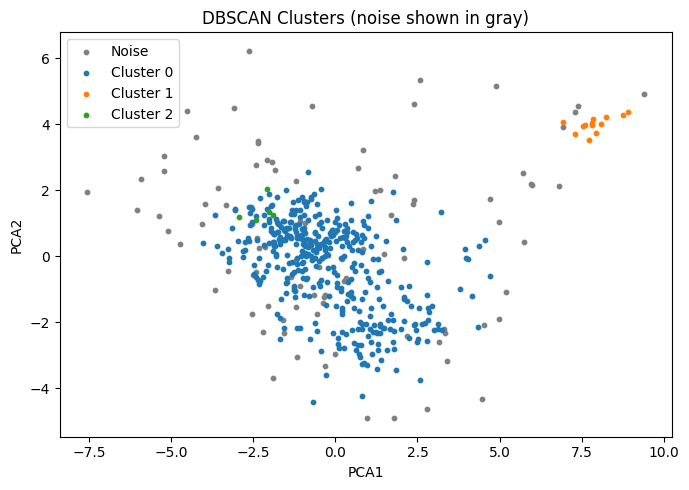

In [306]:
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(df_scaled.drop(columns=['dbscan_label']))
reduced_df = pd.DataFrame(reduced_X, columns=['PCA1', 'PCA2'])
reduced_df['Cluster'] = labels

plt.figure(figsize=(7, 5))
for lab in np.unique(labels):
    mask = reduced_df['Cluster'] == lab
    color = 'gray' if lab == -1 else None
    label = 'Noise' if lab == -1 else f'Cluster {lab}'
    plt.scatter(
        reduced_df.loc[mask, 'PCA1'],
        reduced_df.loc[mask, 'PCA2'],
        s=10,
        label=label,
        color=color,
        cmap='viridis'
    )

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('DBSCAN Clusters (noise shown in gray)')
plt.legend()
plt.tight_layout()
plt.show()


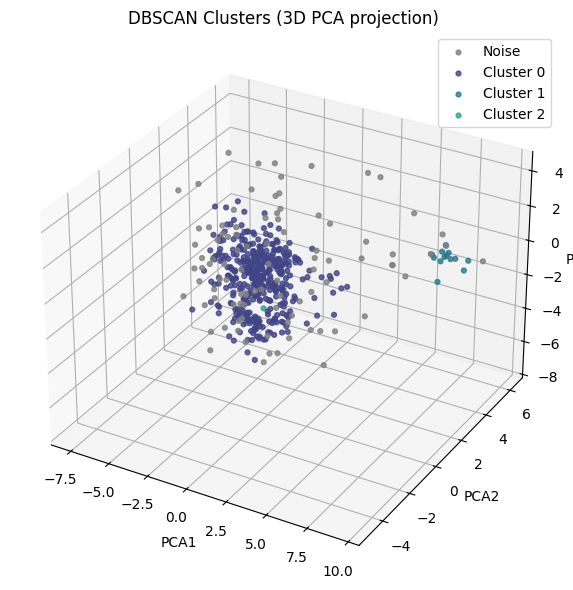

In [307]:
coords_3d, pca_3d = plot_3d_clusters(X_data, labels)


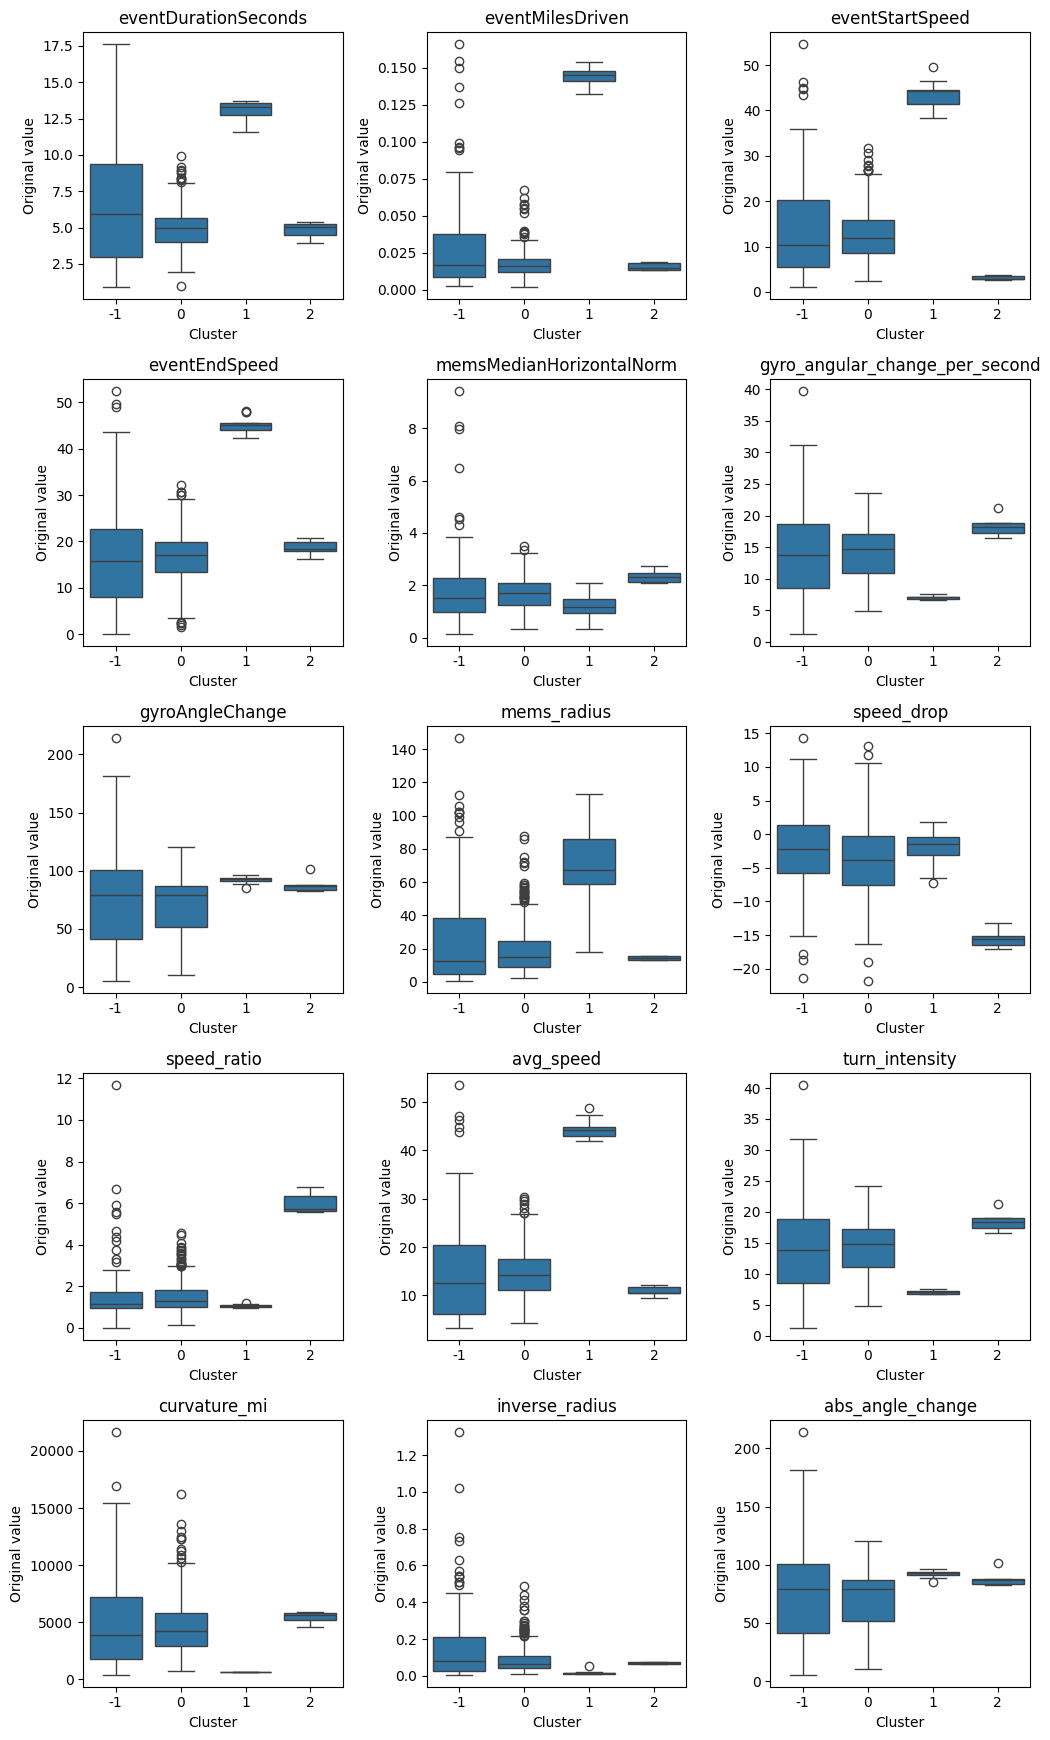

In [308]:
plot_feature_boxplots(sub_df_clustered.drop(columns=['dbscan_label']), labels, value_label='Original value')


In [309]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Convert your DataFrame to numpy array if needed
X_data = df_scaled.values

# Parameter ranges to test
eps_values = np.linspace(0.1, 2.0, 20)        # adjust range to your data scale
min_samples_values = range(2, 21)

results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms).fit(X_data)
        labels = db.labels_

        # Valid only if we have at least 2 clusters (excluding noise)
        unique_labels = set(labels)
        non_noise = [lab for lab in unique_labels if lab != -1]

        if len(non_noise) < 2:
            score = np.nan
        else:
            score = silhouette_score(X_data, labels)

        results.append({
            "eps": eps,
            "min_samples": ms,
            "silhouette": score,
            "n_clusters": len(non_noise)
        })

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Find the best combo
best = results_df.loc[results_df['silhouette'].idxmax()]
print("Best parameters:")
print(best)

Best parameters:
eps            2.000000
min_samples    6.000000
silhouette     0.321112
n_clusters     2.000000
Name: 365, dtype: float64


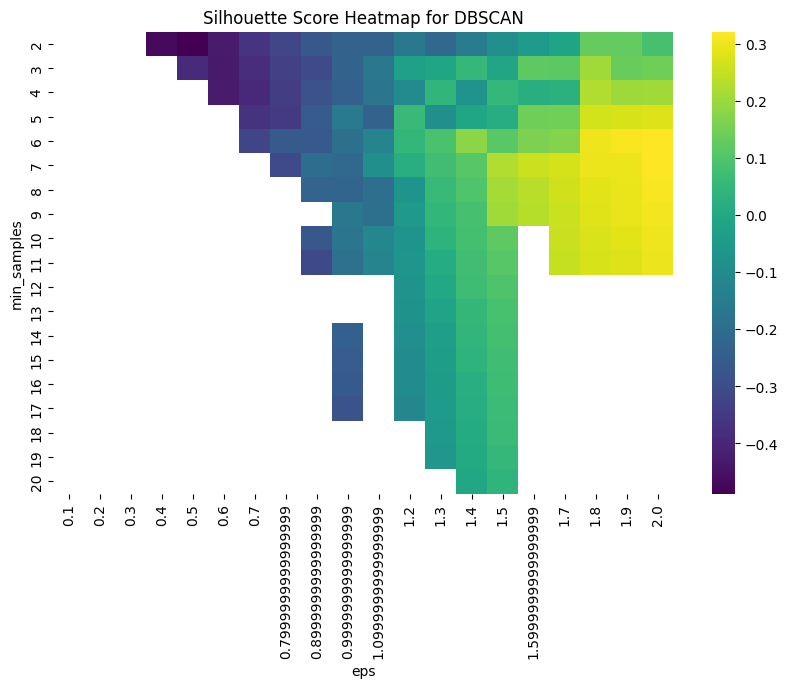

In [310]:
pivot = results_df.pivot(index="min_samples", columns="eps", values="silhouette")

plt.figure(figsize=(10, 6))
plt.title("Silhouette Score Heatmap for DBSCAN")
sns.heatmap(pivot, cmap="viridis", annot=False)
plt.xlabel("eps")
plt.ylabel("min_samples")
plt.show()

In [311]:


best_model = DBSCAN(
    eps=2,
    min_samples=8,
    metric="euclidean",
    n_jobs=-1,
)
labels = best_model.fit_predict(X_data)


df_scaled = df_scaled.drop(columns=['dbscan_label'], errors='ignore')
df_scaled['dbscan_label'] = labels

sub_df_clustered = sub_df_left.copy()
sub_df_clustered['dbscan_label'] = labels


In [312]:
feature_profile = sub_df_clustered.groupby('dbscan_label').agg(['mean', 'median']).T
feature_profile


dbscan_label                                    -1            0           1
eventDurationSeconds           mean       6.400390     4.913482   13.124926
                               median     5.687625     4.958922   13.286063
eventMilesDriven               mean       0.030031     0.016939    0.144836
                               median     0.016617     0.015756    0.145488
eventStartSpeed                mean      14.129529    12.581033   43.373002
                               median     8.525844    11.855412   44.243774
eventEndSpeed                  mean      17.315805    16.381159   45.198638
                               median    16.136505    17.070214   45.149033
memsMedianHorizontalNorm       mean       1.912704     1.690914    1.241423
                               median     1.562431     1.687872    1.174335
gyro_angular_change_per_second mean      14.584567    14.110260    7.040081
                               median    14.149207    14.644554    7.063112
gyroAngleChange                mean      81.379523    69.512213   92.543216
                               median    82.629205    79.006515   93.093920
mems_radius                    mean      27.216546    19.027848   71.729521
                               median    13.166379    15.042291   67.133710
speed_drop                     mean      -3.186276    -3.800126   -1.825636
                               median    -2.455972    -3.773637   -1.395563
speed_ratio                    mean       1.943597     1.470275    1.045501
                               median     1.174279     1.286944    1.033568
avg_speed                      mean      15.722667    14.481096   44.285820
                               median    12.006379    14.347395   44.303349
turn_intensity                 mean      14.740697    14.244761    7.059020
                               median    14.225174    14.765191    7.081623
curvature_mi                   mean    5195.544774  4531.458545  634.951404
                               median  4013.869244  4215.938160  636.619401
inverse_radius                 mean       0.178183     0.090258    0.017296
                               median     0.075945     0.066475    0.014895
abs_angle_change               mean      81.379523    69.512213   92.543216
                               median    82.629205    79.006515   93.093920

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_4192/985858072.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


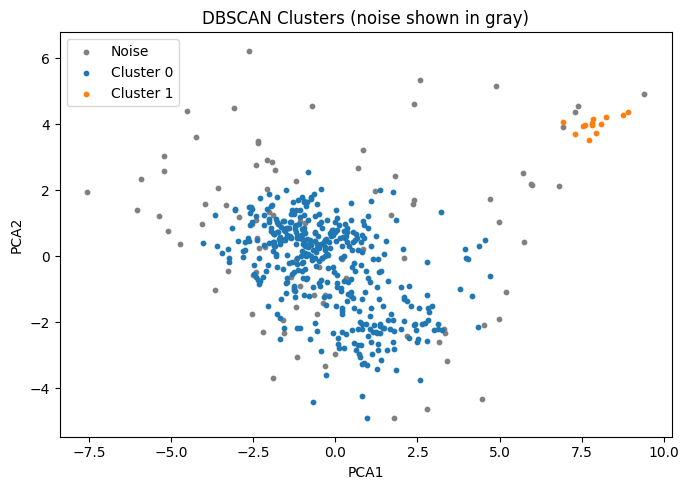

In [313]:
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(df_scaled.drop(columns=['dbscan_label']))
reduced_df = pd.DataFrame(reduced_X, columns=['PCA1', 'PCA2'])
reduced_df['Cluster'] = labels

plt.figure(figsize=(7, 5))
for lab in np.unique(labels):
    mask = reduced_df['Cluster'] == lab
    color = 'gray' if lab == -1 else None
    label = 'Noise' if lab == -1 else f'Cluster {lab}'
    plt.scatter(
        reduced_df.loc[mask, 'PCA1'],
        reduced_df.loc[mask, 'PCA2'],
        s=10,
        label=label,
        color=color,
        cmap='viridis'
    )

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('DBSCAN Clusters (noise shown in gray)')
plt.legend()
plt.tight_layout()
plt.show()


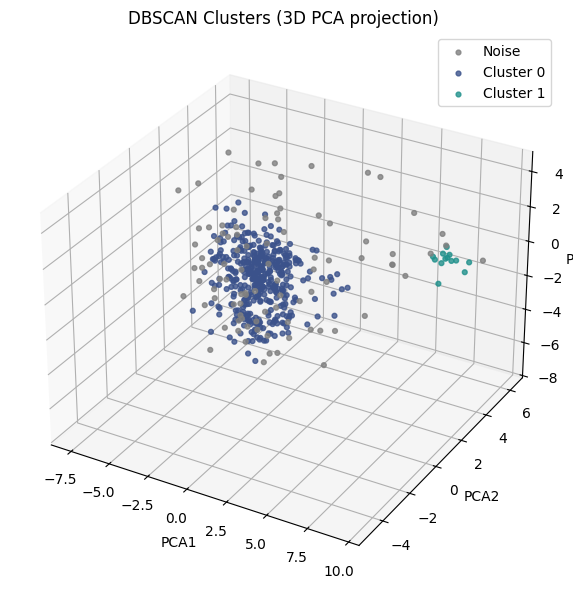

In [314]:
coords_3d, pca_3d = plot_3d_clusters(X_data, labels)


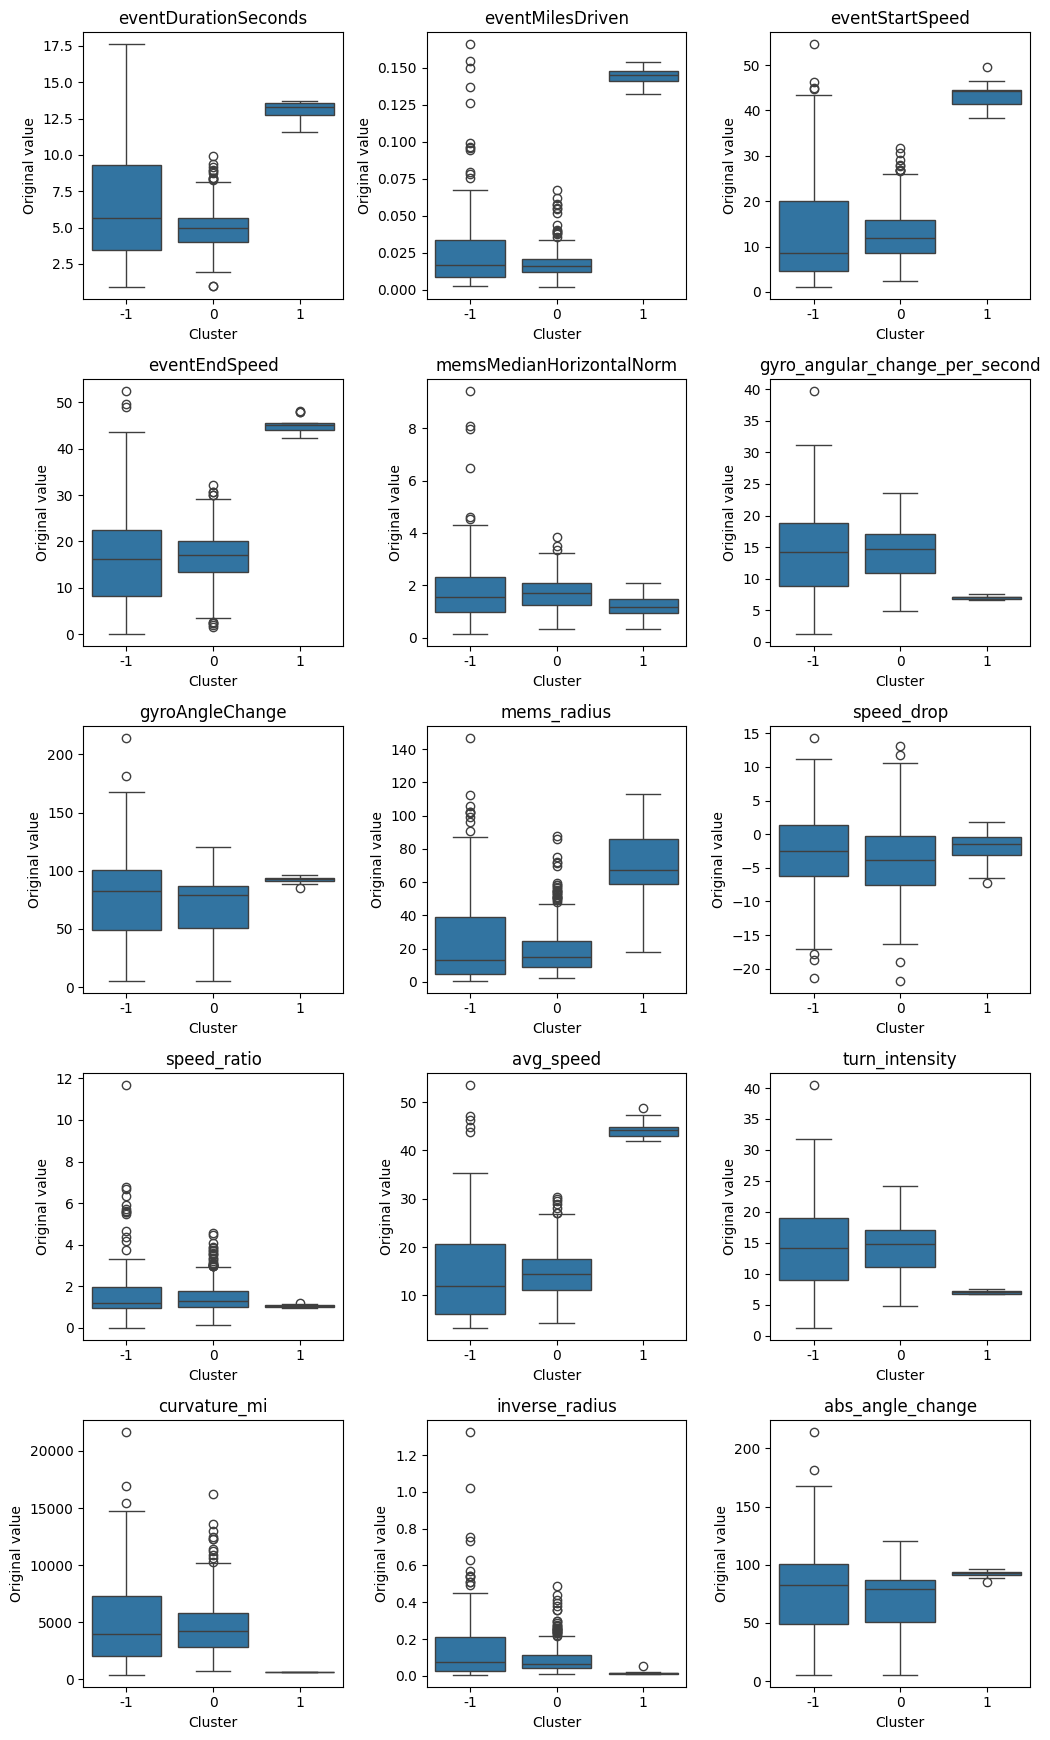

In [315]:
plot_feature_boxplots(sub_df_clustered.drop(columns=['dbscan_label']), labels, value_label='Original value')
